# Основы машинного обучения

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо. Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
проанализировать основные признаки, наиболее сильно влияющие на отток;
сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;

2) предложить меры по снижению оттока;

3) определить другие особенности взаимодействия с клиентами.

## Оглавление

1. [Изучение данных из файла](#id)
2. [Исследовательский анализ данных](#ia)
3. [Модель прогнозирования оттока клиентов](#mp)
4. [Кластеризация клиентов](#kk)
5. [Общий вывод](#ov)

##  1. Изучение данных из файла <a class="anchor" id="id"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
# База по клиентам
gym_data = pd.read_csv('/datasets/gym_churn.csv')
display(gym_data.head())
gym_data.info()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

**Вывод**

В таблице 14 колонок, типы данных - int64, float64.

Столбцы нужно привести к нижнему регистру. Столбец month_to_end_contract нужно перевести в целочисленный формат.

Количество значений в столбцах не различается.

Согласно документации к данным:

* `gender` — пол;
* `near_location` — проживание или работа в районе, где находится фитнес-центр;
* `partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `phone` — наличие контактного телефона;
* `age` — возраст;
* `lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).
* `contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `group_visits` — факт посещения групповых занятий;
* `avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* `churn` — факт оттока в текущем месяце.

## 2. Исследовательский анализ данных (EDA) <a class="anchor" id="ia"></a>

In [3]:
# Привел названия столбцов к нижнему регистру
gym_data.columns = gym_data.columns.str.lower()

# Проверяю наличие пропусков
print('Пропуски в gym_data:', gym_data.isna().sum())

# Проверяю наличие дубликатов
print('Количество дубликатов в gym_data:', gym_data.duplicated().sum())

# Заменяю тип данных на int
gym_data['month_to_end_contract'] = gym_data['month_to_end_contract'].astype('int')

Пропуски в gym_data: gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64
Количество дубликатов в gym_data: 0


In [4]:
# Средние значения признаков
gym_data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Среднее по оттоку равняется 0.27, а медиана 0. Из этого следует, что около 30% клиентов уходит в отток.

In [5]:
# Cредние значения признаков в двух группах - тех, кто ушел в отток и тех, кто остался 
churn_group_mean = gym_data.groupby('churn').mean()
churn_group_mean = churn_group_mean.transpose()
display(churn_group_mean)

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Из таблицы средних значений признаков видно, что по полу имеется примерно равное количество человек в двух группах. Также можно сделать вывод, что более лояльны к фитнес-центру следующие категории: кто живет поблизости, сотрудник компании-партнёра клуба, пришли в рамках акции «приведи друга», длительность текущего действующего абонемента в среднем около 5-6 месяцев, чаще посещает групповые занятия, постарше (к 30), больше тратит на другие услуги фитнес-центра (хотя разница и небольшая), до конца абонемента еще 5-6 месяцев, является постоянным клиентом, посещает фитнес от 2-х раз в неделю. Нет различий между группами в наличии контактного телефона клиентов - практически все оставляют контакты для связи.

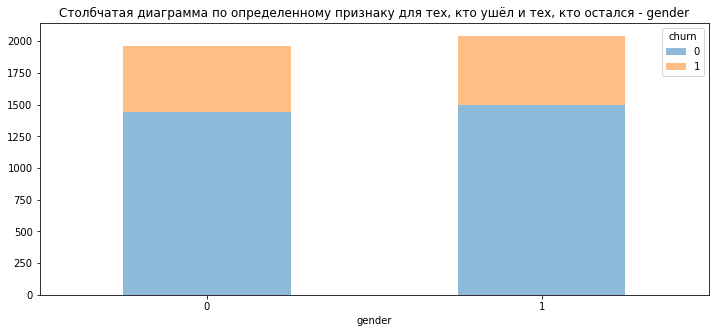

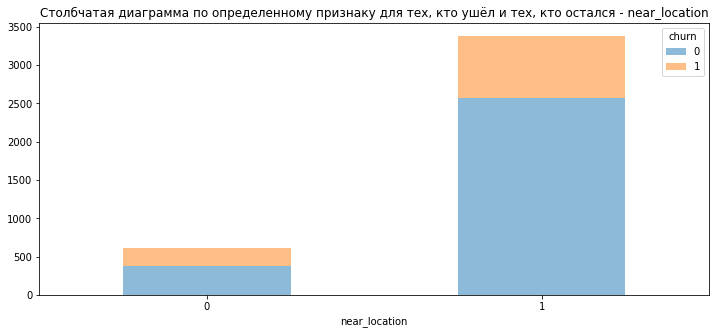

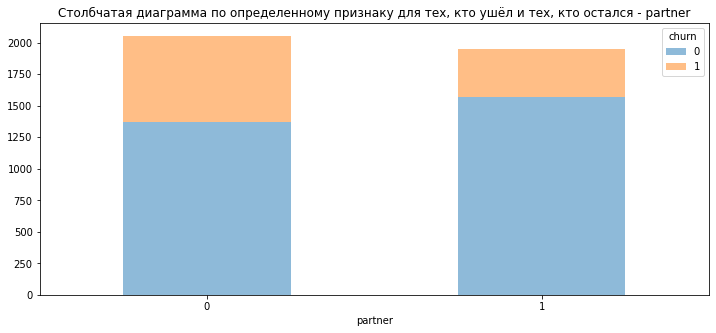

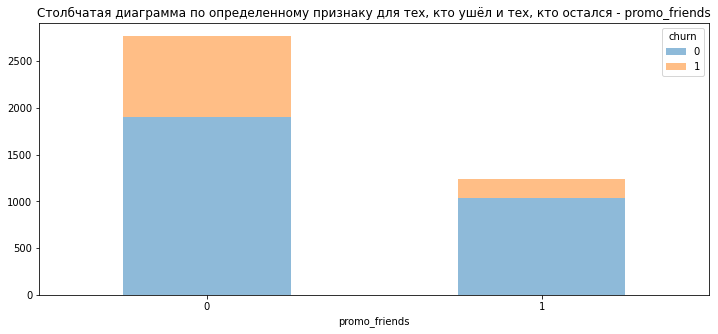

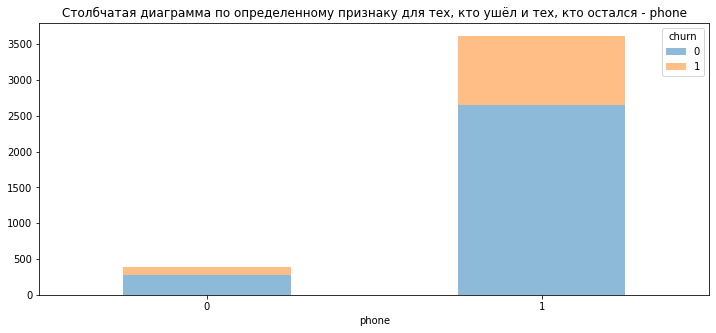

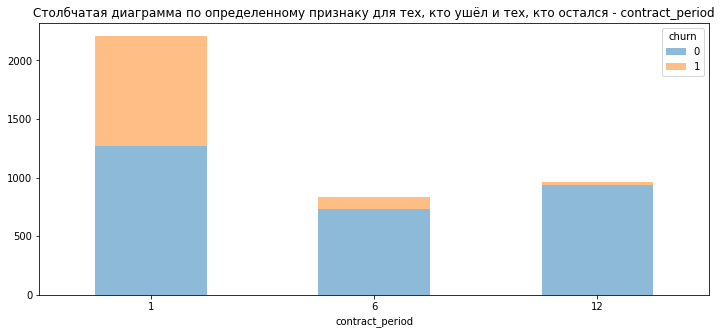

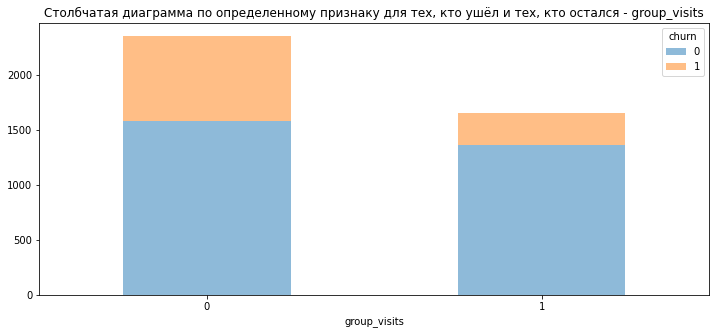

In [6]:
# Столбчатые диаграммы для разных признаков по оттоку
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits']:
    gym_data.pivot_table(index = column, columns = 'churn', 
            values = 'lifetime', aggfunc = 'count').plot(kind = 'bar', stacked = True, alpha = 0.5, figsize=(12, 5))
    plt.title('Столбчатая диаграмма по определенному признаку для тех, кто ушёл и тех, кто остался - ' + column)
    plt.xticks(rotation = 0)
    plt.show()

1. Графики показывают, что по гендору обе группы имеют схожее равномерное распределение. 
2. Клиентов, живущих поблизости, сильно больше, чем тех, кто находится в отдалённости. 
3. Сотрудников компаний-партнёров клуба меньше, чем обычных, однако в отток уходит меньше людей. 
4. Пришедших в рамках акции "Приведи друга" меньше, чем обычных, но и отток там меньше. 
5. По наличию контактного телефона можно сказать, что в выборке больше тех, для кого представлена контактная информация. 
6. Больше всего клиентов с месячным абонементом, отток там тоже очень большой, далее по численности идет годовой абонемент, оттока там почти нет. Меньше всего людей с абонементом в 6 месяцев, по оттоку они на втором месте. 
7. По посещениям групповых занятий, можно сказать, что отток у посещающих сильно меньше.

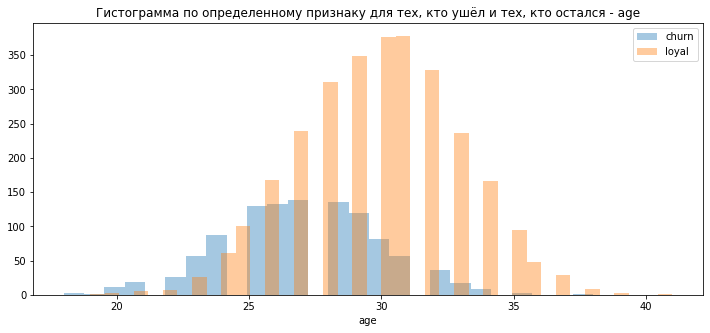

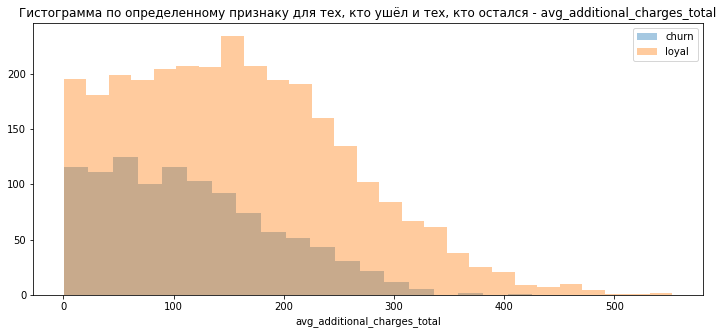

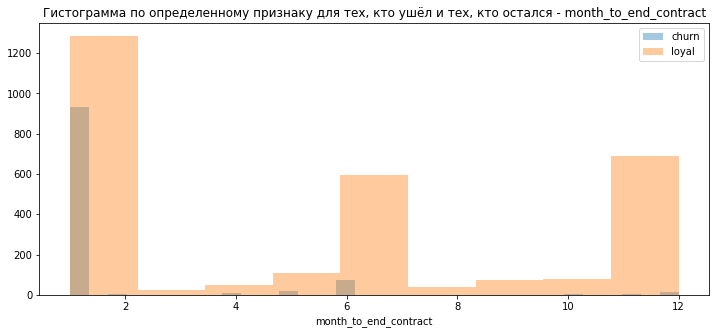

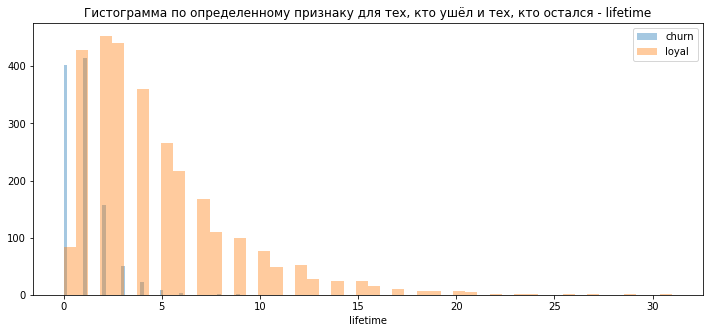

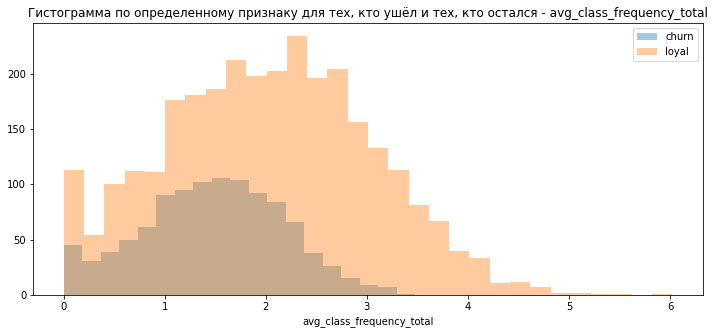

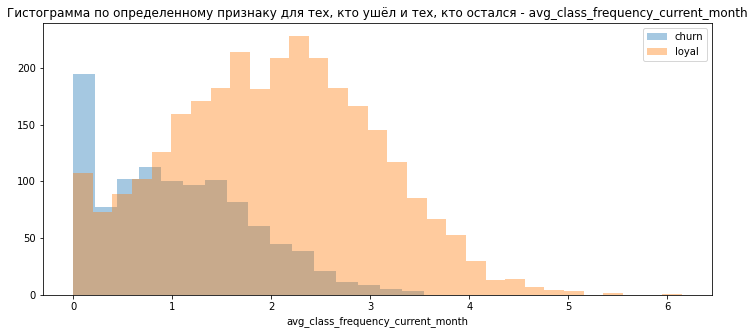

In [7]:
# Гистограмма для разных признаков по оттоку
loyal_clients = gym_data.query('churn == 0')
churn_clients = gym_data.query('churn == 1')

for column in ['age', 'avg_additional_charges_total', 'month_to_end_contract', 
               'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    plt.figure(figsize = (12, 5))
    sns.distplot(churn_clients[column], label='churn', kde = False)
    sns.distplot(loyal_clients[column], label='loyal', kde = False)
    plt.legend()
    plt.title('Гистограмма по определенному признаку для тех, кто ушёл и тех, кто остался - ' + column)
    plt.show()

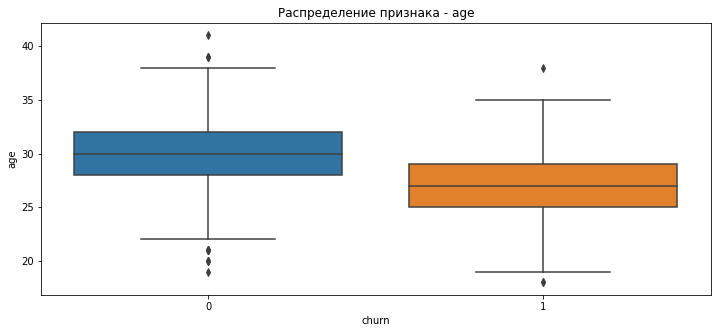

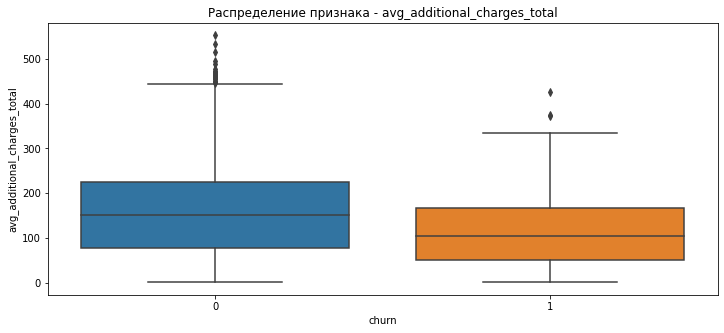

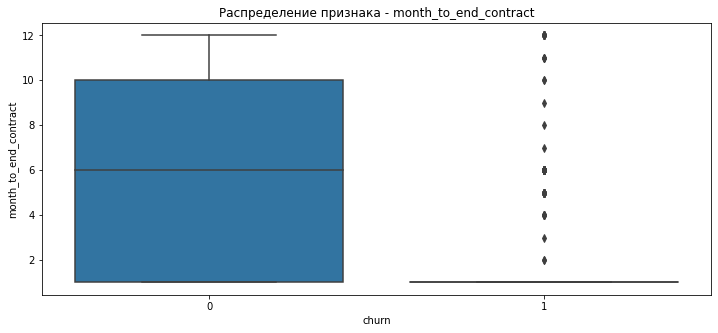

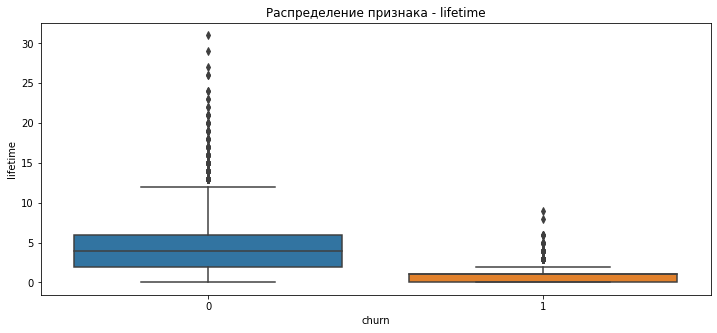

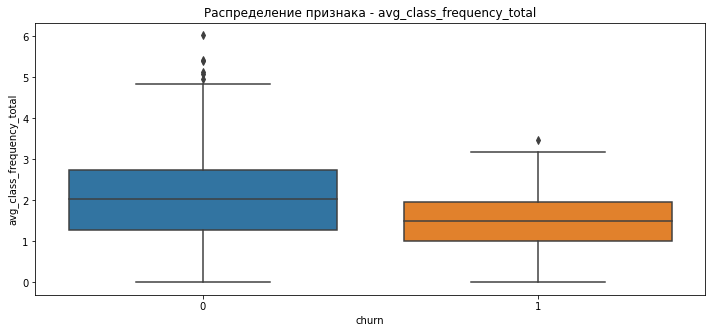

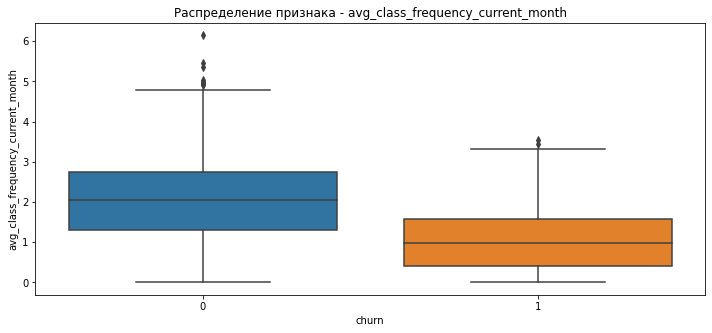

In [8]:
# Боксплоты для разных признаков по оттоку
for column in ['age', 'avg_additional_charges_total', 'month_to_end_contract', 
               'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    plt.figure(figsize = (12, 5))
    plt.title('Распределение признака - ' + column)
    sns.boxplot(x = 'churn', y = column, data = gym_data)
    plt.show()

1. По возрасту обе группы имеют нормальное распределение, но для группы лояльных клиентов немного смещёно вправо, а для ушедших клиентов влево, это говорит о том, что чаще уходят молодые люди (от 25 до 28 лет).
2. По распределению средней выручки от других услуг фитнес-центра для обоих групп смещено влево с большим смещением для ушедших людей, похоже на распределение Пуассона. То есть те, кто уходит, практически ничего не тратят на дополнительные услуги в фитнес-центре.
3. Распределение лайвтайма для обоих групп похоже на распределение Пуассона. Для ушедших в отток клиентов оно сильно смещено влево, что доказывает, что уходят не постоянные клиенты.
4. Распределение для средней частоты посещений в неделю за все время с начала действия абонемента в обоих группах является нормальным. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток смещёно влево. Также происходит и распределением для средней частоты посещений в неделю за предыдущий месяц. Это говорит, о том, что чаще уходят те, кто редко занимается. 

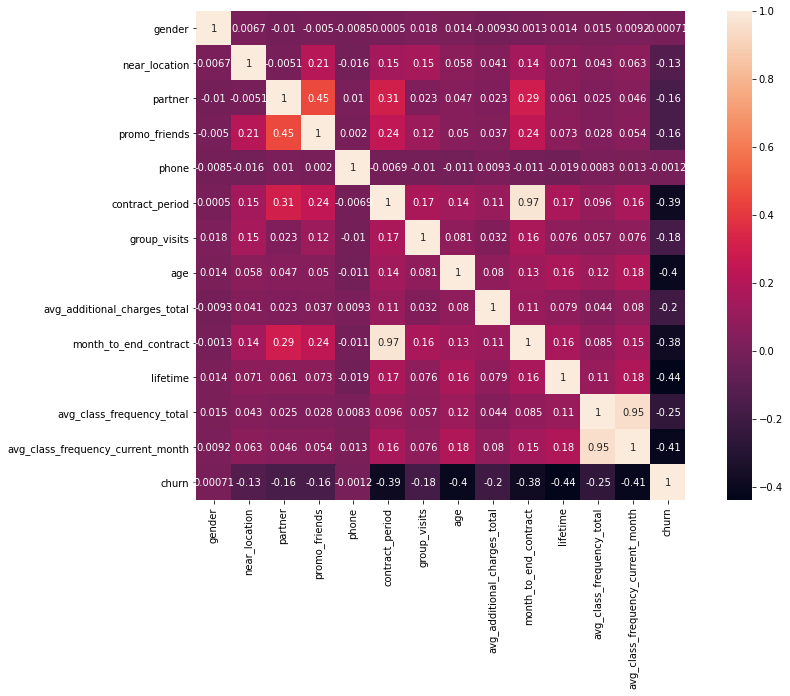

In [9]:
# Тепловая карта с подписями для матрицы корреляций
cm = gym_data.corr()
plt.figure(figsize = (15, 9))
sns.heatmap(cm, annot=True, square=True)
plt.show()

На тепловой карте видно, что сильно коррелируют средняя частота посещений в неделю за предыдущий месяц и средняя частота посещений в неделю за все время с начала действия абонемента. Также как и длительность текущего действующего абонемента со срок до окончания текущего действующего абонемента. А вот такие признаки как пол и наличие контактного телефона почти не влияют на отток.

**Вывод**

1. Дубликатов и пропусков не обнаружил. Перевел столбец month_to_end_contract в целочисленный формат. Также привел столбцы к нижнему регистру для удобства. 
2. Признаки в базе числовые.
3. Из таблицы средних значений признаков видно, что по полу имеется примерно равное количество человек в двух группах. Также можно сделать вывод, что более лояльны к фитнес-центру следующие категории: кто живет поблизости, сотрудник компании-партнёра клуба, пришли в рамках акции «приведи друга», длительность текущего действующего абонемента в среднем около 5-6 месяцев, чаще посещает групповые занятия, постарше (к 30), больше тратит на другие услуги фитнес-центра (хотя разница и небольшая), до конца абонемента еще 5-6 месяцев, является постоянным клиентом, посещает фитнес от 2-х раз в неделю. Нет различий между группами в наличии контактного телефона клиентов - практически все оставляют контакты для связи.
4. Графики показывают, что по гендору обе группы имеют схожее равномерное распределение. Клиентов, живущих поблизости, сильно больше, чем тех, кто находится в отдалённости. Сотрудников компаний-партнёров клуба меньше, чем обычных, однако в отток уходит меньше людей. Пришедших в рамках акции "Приведи друга" меньше, чем обычных, но и отток там меньше. По наличию контактного телефона можно сказать, что в выборке больше тех, для кого представлена контактная информация. Больше всего клиентов с месячным абонементом, отток там тоже очень большой, далее по численности идет годовой абонемент, оттока там почти нет. Меньше всего людей с абонементом в 6 месяцев, по оттоку они на втором месте. По посещениям групповых занятий, можно сказать, что отток у посещающих сильно меньше.
5. По возрасту обе группы имеют нормальное распределение, но для группы лояльных клиентов немного смещёно вправо, а для ушедших клиентов влево, это говорит о том, что чаще уходят молодые люди (от 25 до 28 лет). По распределению средней выручки от других услуг фитнес-центра для обоих групп смещено влево с большим смещением для ушедших людей, похоже на распределение Пуассона. То есть те, кто уходит, практически ничего не тратят на дополнительные услуги в фитнес-центре. Распределение лайвтайма для обоих групп похоже на распределение Пуассона. Для ушедших в отток клиентов оно сильно смещено влево, что доказывает, что уходят не постоянные клиенты. Распределение для средней частоты посещений в неделю за все время с начала действия абонемента в обоих группах является нормальным. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток смещёно влево. Также происходит и распределением для средней частоты посещений в неделю за предыдущий месяц. Это говорит, о том, что чаще уходят те, кто редко занимается.
6. На тепловой карте видно, что сильно коррелируют средняя частота посещений в неделю за предыдущий месяц и средняя частота посещений в неделю за все время с начала действия абонемента. Также как и длительность текущего действующего абонемента со срок до окончания текущего действующего абонемента. А вот такие признаки как пол и наличие контактного телефона почти не влияют на отток.

## 3. Модель прогнозирования оттока клиентов <a class="anchor" id="mp"></a>

In [10]:
# Разделение данных на признаки (матрица X) и целевую переменную (y)
X = gym_data.drop(columns=['churn'])
y = gym_data['churn']

# Разделение модели на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Cтандартизация данных
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# Задаю алгоритм для модели логистической регрессии
log_model = LogisticRegression(random_state=0)

# Обучение модели
log_model.fit(X_train_st, y_train)

# Прогнозы
log_predictions = log_model.predict(X_test_st)
log_probabilities = log_model.predict_proba(X_test_st)[:,1]

# Метрики логистической регрессии
print('Метрики логистической регрессии:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, log_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, log_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, log_predictions)))

Метрики логистической регрессии:
Accuracy: 0.92
Precision: 0.85
Recall: 0.83


In [11]:
# Задаю алгоритм для модели случайного леса
rf_model = RandomForestClassifier(random_state=0)

# Обучение модели
rf_model.fit(X_train_st, y_train)

# Прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

# Метрики случайного леса
print('Метрики случайного леса:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Метрики случайного леса:
Accuracy: 0.92
Precision: 0.84
Recall: 0.81


Обе модели неплохо справились, но у логистической регрессии метрики лучше, чем у случайного леса.  

**Вывод**

Были построены и обучены две модели: алгоритмом логистической регрессии и алгоритмом случайного леса. Произведено разделение выборки на обучащую и валидационную в соотношении 80 к 20. Логистическая регрессия справилась лучше, чем случайный лес. Хотя стоит отметить, что показатели у обеих моделей неплохие.

## 4. Кластеризация клиентов <a class="anchor" id="kk"></a>

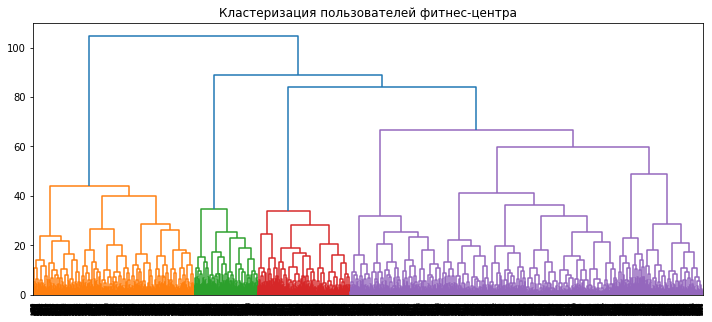

In [12]:
# Cтандартизация данных
scaler = StandardScaler()
x_sc = scaler.fit_transform(X)

# Дендрограмма
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(12, 5))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей фитнес-центра')
plt.show() 

Исходя из дендрограммы, оптимальное число кластеров 4.

In [13]:
# Задаю модель k_means с числом кластеров 5 и фиксирую значение random_state
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(x_sc)

# Сохраняю метки кластера в поле нашего датасета
gym_data['cluster_km'] = labels
display(gym_data.groupby('cluster_km').mean())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.50,0.96,0.78,0.57,1.00,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97,0.03
1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
2,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51
4,0.56,0.98,0.36,0.23,1.00,2.67,0.47,30.13,161.66,2.46,4.90,2.85,2.85,0.07


По данным таблицы уже можно выделить несколько групп (в кластер 2 входят клиенты не живущие поблизости, в 1 кластер входят клиенты без контактного телефона), но для более точного разделения нужно построить распределения признаков для кластеров.

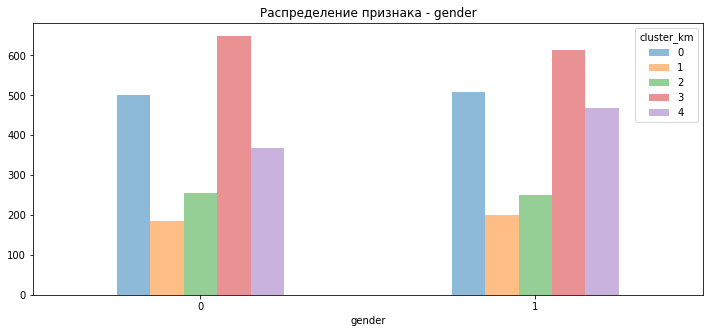

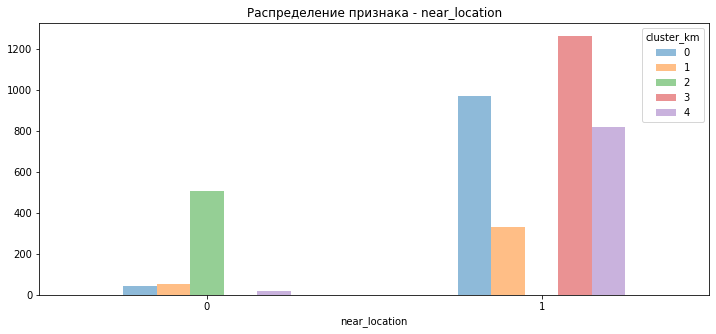

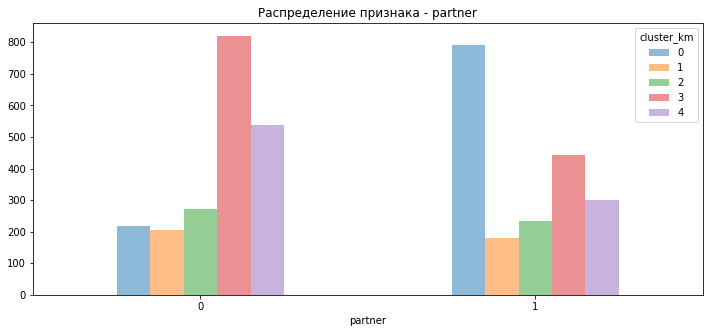

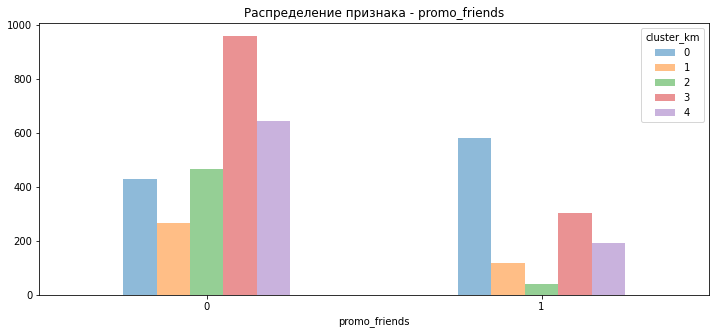

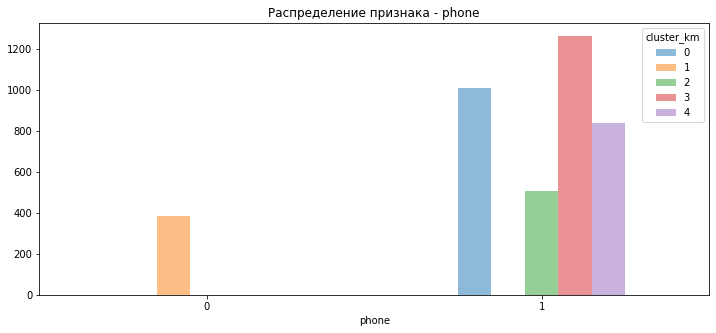

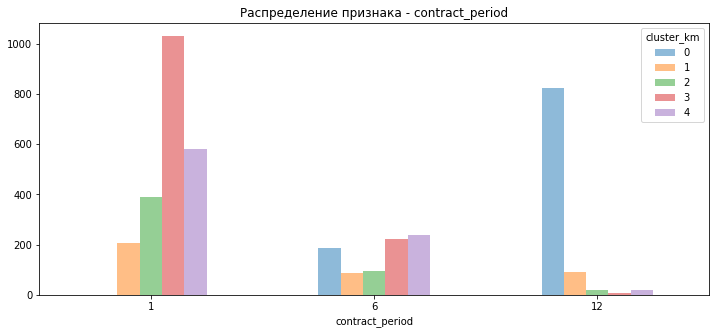

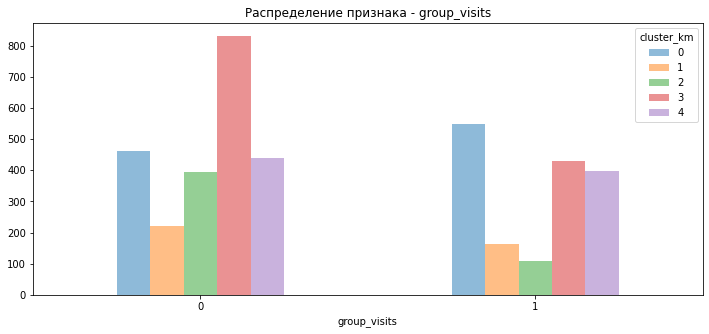

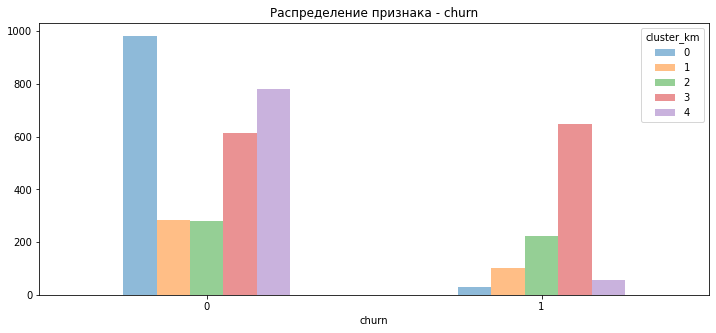

In [14]:
# Столбчатые диаграммы для разных признаков по кластерам
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'churn']:
    gym_data.pivot_table(index = column, columns = 'cluster_km', 
            values = 'lifetime', aggfunc = 'count').plot(kind = 'bar', alpha = 0.5, figsize=(12, 5))
    plt.title('Распределение признака - ' + column)
    plt.xticks(rotation = 0)
    plt.show()

Кластер 0: приблизительно равное соотношение мужчин и женщин, большинство живет поблизости от фитнес-центра, большинство состоит в сотрудничестве с компаниями-партнёрами, около 60% пришли по акции "Приведи друга", остальные ~40% нет, есть контактный телефон, длительность текущего действующего абонемента в основном 1 год, приблизительно равное соотношение по групповым занятиям, почти не уходит в отток.

Кластер 1: приблизительно равное соотношение мужчин и женщин, большинство живет поблизости от фитнес-центра, приблизительно равное соотношение по сотрудничеству с компаниями-партнёрами, большинство пришли не по акции "Приведи друга", нет контактного телефона, длительность текущего действующего абонемента в основном 1 месяц у ~50%, для остальных ~50% приблизительно равное соотношение (полгода и год), по групповым занятиям приблизительно равное соотношение, в отток уходит около 25%.

Кластер 2: приблизительно равное соотношение мужчин и женщин, не живут поблизости от фитнес-центра, приблизительно равное соотношение по сотрудничеству с компаниями-партнёрами, пришли не по акции "Приведи друга", есть контактный телефон, длительность текущего действующего абонемента в основном 1 месяц, в основном не посещают групповые занятия, приблизительно равное соотношение по оттоку (~60 на 40).

Кластер 3: приблизительно равное соотношение мужчин и женщин, живут поблизости от фитнес-центра, большинство не состоит в сотрудничестве с компаниями-партнёрами (около 65 на 35), большинство пришли не по акции "Приведи друга", есть контактный телефон, длительность текущего действующего абонемента в основном 1 месяц, в основном не посещают групповые занятия (~65 на 35), приблизительно равное соотношение по оттоку, больше половины уходит (большая часть клиентов уходит из фитнес-центра именно из этого кластера).

Кластер 4: женщин больше, чем мужчин, большинство живет поблизости от фитнес-центра, большинство не состоит в сотрудничестве с компаниями-партнёрами (~65 на 35), большинство пришли не по акции "Приведи друга", есть контактный телефон, длительность текущего действующего абонемента в основном 1 месяц, приблизительно равное соотношение по групповым занятиям, почти не уходит в отток.

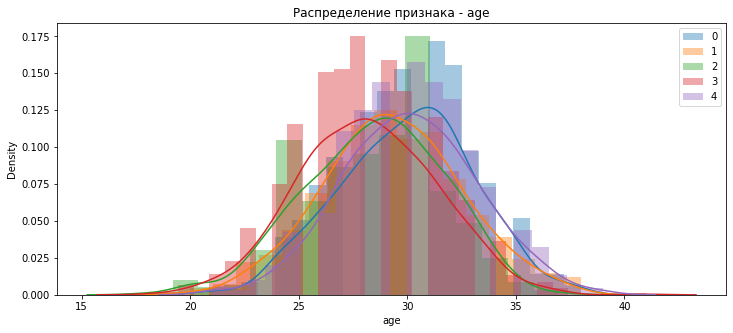

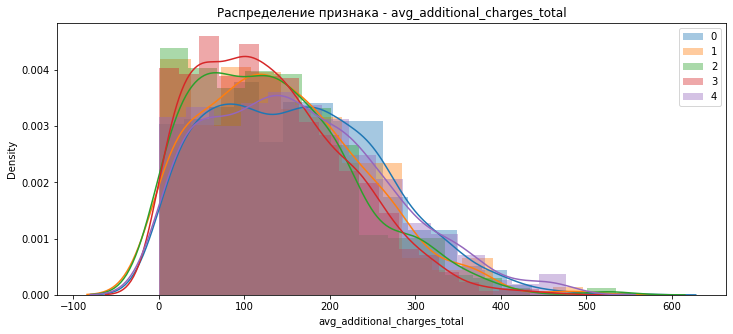

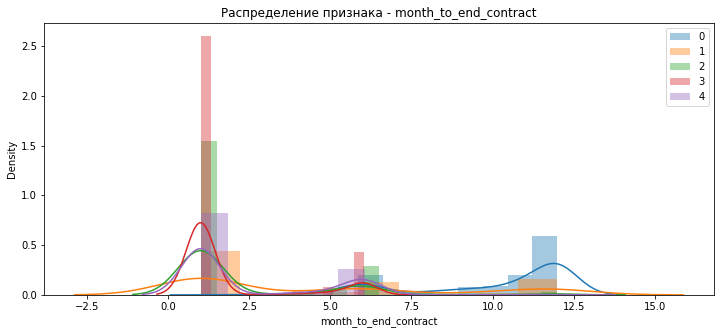

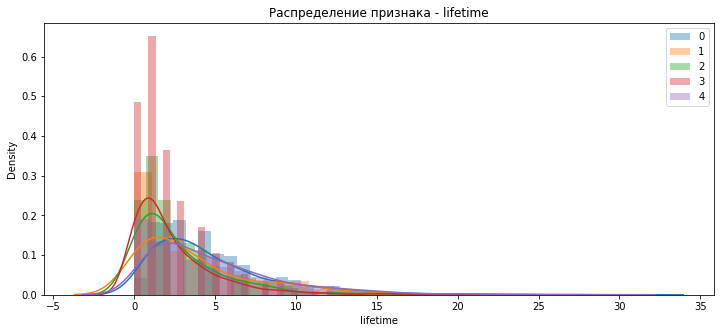

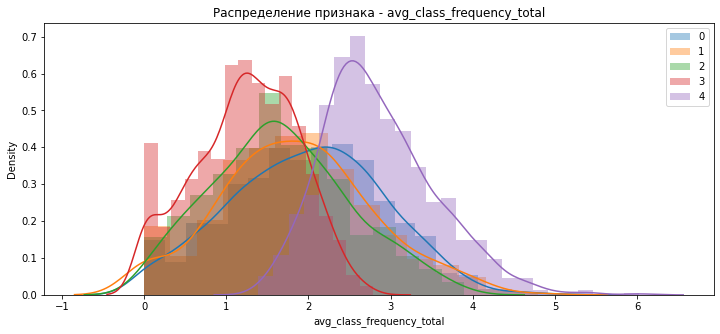

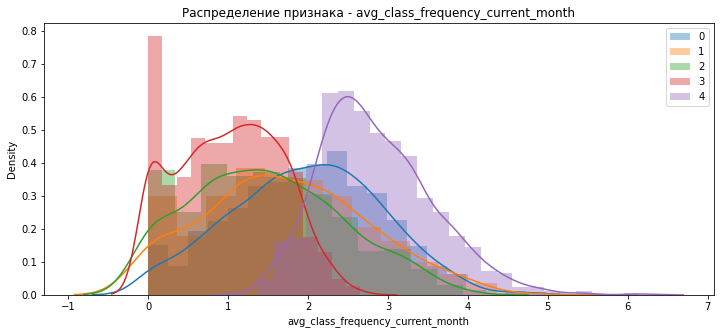

In [15]:
# Гистограмма для разных признаков по кластерам
cluster_0 = gym_data.query('cluster_km == 0')
cluster_1 = gym_data.query('cluster_km == 1')
cluster_2 = gym_data.query('cluster_km == 2')
cluster_3 = gym_data.query('cluster_km == 3')
cluster_4 = gym_data.query('cluster_km == 4')

for column in ['age', 'avg_additional_charges_total', 'month_to_end_contract', 
               'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    plt.figure(figsize = (12, 5))
    sns.distplot(cluster_0[column], label='0', kde = True)
    sns.distplot(cluster_1[column], label='1', kde = True)
    sns.distplot(cluster_2[column], label='2', kde = True)
    sns.distplot(cluster_3[column], label='3', kde = True)
    sns.distplot(cluster_4[column], label='4', kde = True)
    plt.legend()
    plt.title('Распределение признака - ' + column)
    plt.show()

Для удобства можно построить еще и боксплоты.

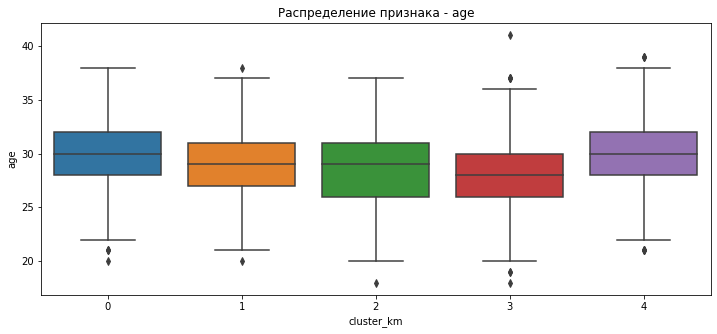

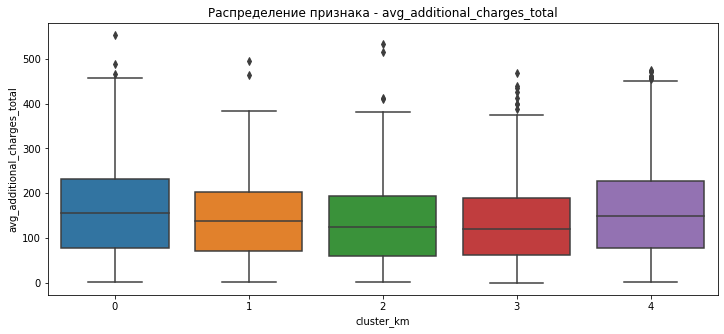

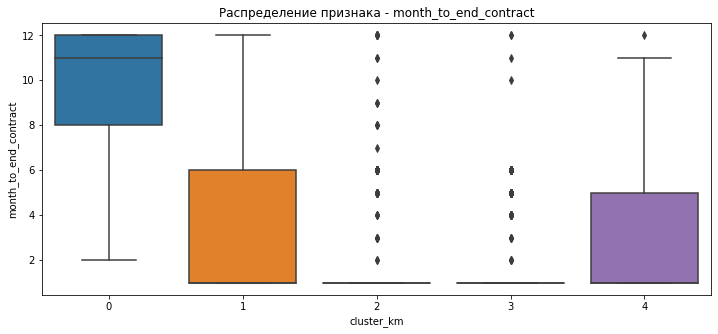

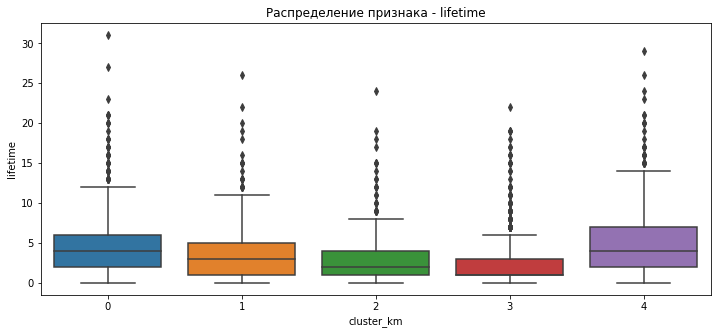

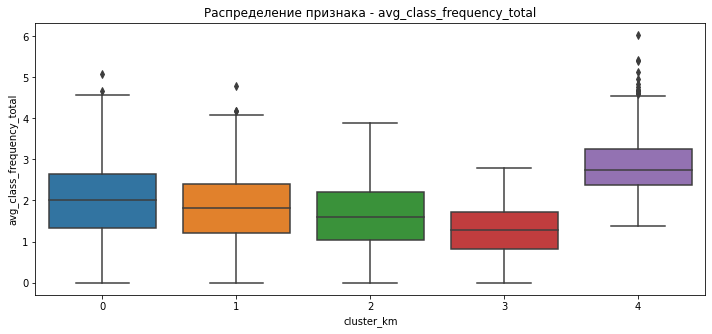

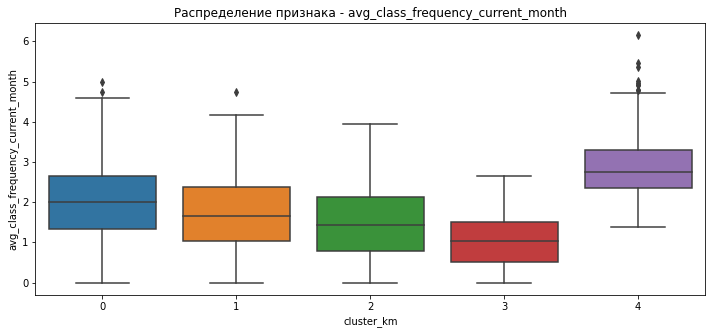

In [16]:
# Боксплоты для разных признаков по кластерам
for column in ['age', 'avg_additional_charges_total', 'month_to_end_contract', 
               'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    plt.figure(figsize = (12, 5))
    plt.title('Распределение признака - ' + column)
    sns.boxplot(x = 'cluster_km', y = column, data = gym_data)
    plt.show()

Кластер 0: за 30 лет, высоким уровнем затрат на другие услуги фитнес-центра, срок до окончания текущего действующего абонемента около 12 месяцев, длительный срок пользования услугами фитнес-центра (от 3 лет), посещает около 2 раз в неделю.

Кластер 1: около 29 лет, средним уровнем затрат на другие услуги фитнес-центра, срок до окончания текущего действующего абонемента от 1, 6 и 12 месяцев с преобладанием абонемента на 1 месяц, длительный срок пользования услугами фитнес-центра (от 2 лет), посещает около 2 раз в неделю.

Кластер 2: около 28 лет, низким уровнем затрат на другие услуги фитнес-центра, срок до окончания текущего действующего абонемента 1-2 месяца, не очень длительный срок пользования услугами фитнес-центра (от 1 года), посещает около 1-2 раза в неделю.

Кластер 3: около 27 лет, низким уровнем затрат на другие услуги фитнес-центра, срок до окончания текущего действующего абонемента 1 месяц, не очень длительный срок пользования услугами фитнес-центра (от 1 года), посещает около 1 раза в неделю.

Кластер 4: за 30 лет, высоким уровнем затрат на другие услуги фитнес-центра, срок до окончания текущего действующего абонемента от 1 до 6 месяцев, длительный срок пользования услугами фитнес-центра (от 3 лет), посещает около 3 раз в неделю.

In [17]:
# Доля оттока для каждого кластера
(gym_data
     .groupby('cluster_km')['churn'].mean().reset_index()
     .sort_values(by='churn', ascending=False)
     .reset_index(drop=True)
)

,cluster_km,churn
0,3,0.51
1,2,0.44
2,1,0.27
3,4,0.07
4,0,0.03


В кластере 3 самый большой отток 51%, далее идут кластер 2 с 44% и кластер 1 с 27%. Самые надежные кластеры 4 и 0, там процентные пункты состовляют 7 и 3%.  

**Вывод**

1. Распределение по кластерам:

Кластер 0: приблизительно равное соотношение мужчин и женщин, большинство живет поблизости от фитнес-центра, большинство состоит в сотрудничестве с компаниями-партнёрами, около 60% пришли по акции "Приведи друга", остальные ~40% нет, есть контактный телефон, длительность текущего действующего абонемента в основном 1 год, приблизительно равное соотношение по групповым занятиям, почти не уходит в отток, за 30 лет, высоким уровнем затрат на другие услуги фитнес-центра, срок до окончания текущего действующего абонемента около 12 месяцев, длительный срок пользования услугами фитнес-центра (от 3 лет), посещает около 2 раз в неделю.

Кластер 1: приблизительно равное соотношение мужчин и женщин, большинство живет поблизости от фитнес-центра, приблизительно равное соотношение по сотрудничеству с компаниями-партнёрами, большинство пришли не по акции "Приведи друга", нет контактного телефона, длительность текущего действующего абонемента в основном 1 месяц у ~50%, для остальных ~50% приблизительно равное соотношение (полгода и год), по групповым занятиям приблизительно равное соотношение, в отток уходит около 25%, около 29 лет, средним уровнем затрат на другие услуги фитнес-центра, срок до окончания текущего действующего абонемента от 1, 6 и 12 месяцев с преобладанием абонемента на 1 месяц, длительный срок пользования услугами фитнес-центра (от 2 лет), посещает около 2 раз в неделю.

Кластер 2: приблизительно равное соотношение мужчин и женщин, не живут поблизости от фитнес-центра, приблизительно равное соотношение по сотрудничеству с компаниями-партнёрами, пришли не по акции "Приведи друга", есть контактный телефон, длительность текущего действующего абонемента в основном 1 месяц, в основном не посещают групповые занятия, приблизительно равное соотношение по оттоку (~60 на 40), около 28 лет, низким уровнем затрат на другие услуги фитнес-центра, срок до окончания текущего действующего абонемента 1-2 месяца, не очень длительный срок пользования услугами фитнес-центра (от 1 года), посещает около 1-2 раза в неделю.

Кластер 3: приблизительно равное соотношение мужчин и женщин, живут поблизости от фитнес-центра, большинство не состоит в сотрудничестве с компаниями-партнёрами (около 65 на 35), большинство пришли не по акции "Приведи друга", есть контактный телефон, длительность текущего действующего абонемента в основном 1 месяц, в основном не посещают групповые занятия (~65 на 35), приблизительно равное соотношение по оттоку, больше половины уходит (большая часть клиентов уходит из фитнес-центра именно из этого кластера), около 27 лет, низким уровнем затрат на другие услуги фитнес-центра, срок до окончания текущего действующего абонемента 1 месяц, не очень длительный срок пользования услугами фитнес-центра (от 1 года), посещает около 1 раза в неделю.

Кластер 4: женщин больше, чем мужчин, большинство живет поблизости от фитнес-центра, большинство не состоит в сотрудничестве с компаниями-партнёрами (~65 на 35), большинство пришли не по акции "Приведи друга", есть контактный телефон, длительность текущего действующего абонемента в основном 1 месяц, приблизительно равное соотношение по групповым занятиям, почти не уходит в отток, за 30 лет, высоким уровнем затрат на другие услуги фитнес-центра, срок до окончания текущего действующего абонемента от 1 до 6 месяцев, длительный срок пользования услугами фитнес-центра (от 3 лет), посещает около 3 раз в неделю.

2. В кластере 3 самый большой отток 51%, далее идут кластер 2 с 44% и кластер 1 с 27%. Самые надежные кластеры 4 и 0, там процентные пункты состовляют 7 и 3%.


## 5. Общий вывод <a class="anchor" id="ov"></a>

По данным сети фитнес-центров «Культурист-датасаентист», можно сделать несколько выводов:

1. В базе данных содержится информация о 4000 клиентах и 14 показателях. На этапе предобработки были переименованы столбцы согласно нижнему регистру. Пропусков и дубликатов не обнаружено. Столбец month_to_end_contract был переведен в целочисленный формат. Признаки в базе числовые. 
2. Исследовательский анализ данных (EDA) показал, что около 30% клиентов уходит в отток. Графики показывают, что по гендору обе группы имеют схожее равномерное распределение. Клиентов, живущих поблизости, сильно больше, чем тех, кто находится в отдалённости. Сотрудников компаний-партнёров клуба меньше, чем обычных, однако в отток уходит меньше людей. Пришедших в рамках акции "Приведи друга" меньше, чем обычных, но и отток там меньше. По наличию контактного телефона можно сказать, что в выборке больше тех, для кого представлена контактная информация. Больше всего клиентов с месячным абонементом, отток там тоже очень большой, далее по численности идет годовой абонемент, оттока там почти нет. Меньше всего людей с абонементом в 6 месяцев, по оттоку они на втором месте. По посещениям групповых занятий, можно сказать, что отток у посещающих сильно меньше. По возрасту обе группы имеют нормальное распределение, но для группы лояльных клиентов немного смещёно вправо, а для ушедших клиентов влево, это говорит о том, что чаще уходят молодые люди (от 25 до 28 лет). По распределению средней выручки от других услуг фитнес-центра для обоих групп смещено влево с большим смещением для ушедших людей, похоже на распределение Пуассона. То есть те, кто уходит, практически ничего не тратят на дополнительные услуги в фитнес-центре. Распределение лайвтайма для обоих групп похоже на распределение Пуассона. Для ушедших в отток клиентов оно сильно смещено влево, что доказывает, что уходят не постоянные клиенты. Распределение для средней частоты посещений в неделю за все время с начала действия абонемента в обоих группах является нормальным. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток смещёно влево. Также происходит и распределением для средней частоты посещений в неделю за предыдущий месяц. Это говорит, о том, что чаще уходят те, кто редко занимается. На тепловой карте видно, что сильно коррелируют средняя частота посещений в неделю за предыдущий месяц и средняя частота посещений в неделю за все время с начала действия абонемента. Также как и длительность текущего действующего абонемента со срок до окончания текущего действующего абонемента. А вот такие признаки как пол и наличие контактного телефона почти не влияют на отток.
3. Среди двух моделей прогнозирования оттока клиентов логистическая регрессия справилась лучше.
4. По данным датасета было выделено 5 кластеров с со своими отличительными признаками. Анализ средних значений и распределений признаков показал что, в кластере 3 самый большой отток 51%. Самые надежные кластеры 4 и 0, там процентные пункты состовляют 7 и 3%. 

Рекомендации для стратегии взаимодействия с клиентами и их удержания:
1. Увеличить количество компаний-партнёров клуба из близлежащих районов. Исследование показало, что отток по сотрудникам этих компаний меньше. Также нужно проводить больше акций, таких как "Приведи друга". По этой акции уходит меньше людей. Заниматься не одному всегда проще.
2. Увеличить число постоянных клиентов за счет скидок на продажи годовых и полугодовых абонементов. Отток у тех, кто приобрел себе абонемент на 6 или 12 месяцев меньше, чем у тех, кто взял на месяц. Скидки на данные абонементы, возможно даже персональные скидки, обеспечат переход клиентов в постоянные клиенты. Отток по таким клиентам меньше, и исследование это доказало.
3. Улучшить и разнообразить групповые занятия, увеличить их количество. На графиках видно, что люди посещающие данные мероприятия уходят реже.
4. Установление или улучшение обратной связи, чтобы узнать отношение клиентов к тем или иным изменениям. Также можно придумать программу лояльности, чтобы превратить разовых клиентов в постоянных и стимулировать их покупать чаще и больше.